In [1]:
import pandas as pd
import os
import numpy as np
import random 
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/project_data/train_data.csv')
data = train_data.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


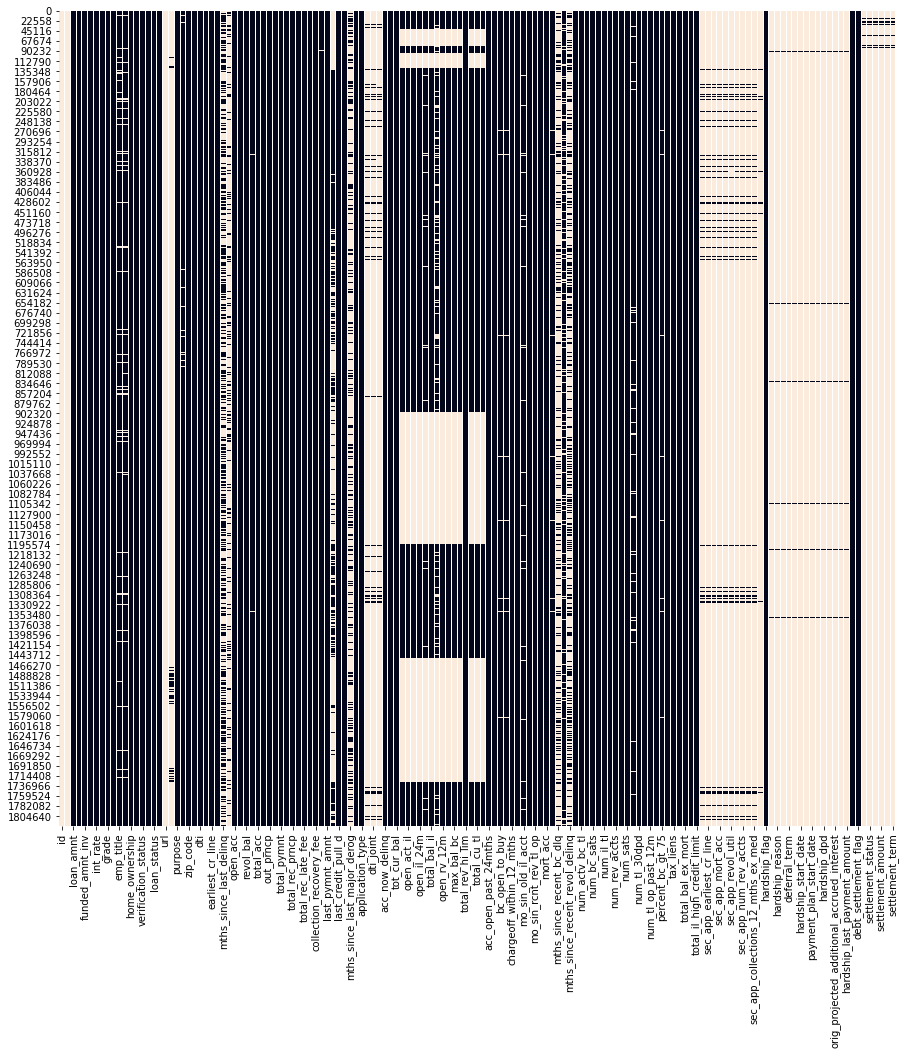

In [3]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(train_data.isnull(), cbar=False)

In [3]:
feature_description = pd.read_excel('/content/drive/My Drive/Colab Notebooks/project_data/data_dictionary.xlsx')
feature_description

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
148,settlement_amount,The loan amount that the borrower has agreed t...
149,settlement_percentage,The settlement amount as a percentage of the p...
150,settlement_term,The number of months that the borrower will be...
151,NaN,NaN


### Data Preprocessing

In [4]:
def data_preprocessing(data, miss_threshold, category):
    '''
    Data: dataframe type original data
    miss_threhold: float type, determine whether keep the feature
    category: boolean type, determine whether keep categoical data
    '''
    if category == False: 
        categorical = []
        for name in data.columns:
            for x in data[name][data[name].isna() == False]:
                if type(x) != str:
                    categorical.append(name)
                    break
        data = data[categorical]
                
    
    data = data[[x for x in data.columns if (sum(data[x].isna())/len(data)) <= miss_threshold]]
    unchanged_feature = [x for x in data.columns if len(data[x].unique()) == 1]
    data = data.drop(unchanged_feature, axis = 1)
    
    return data
    

In [5]:
label = data['loan_status']
data = data.drop(['loan_status'], axis = 1)

for i in range(len(label)):
    if label[i] == 'Charged Off':
        label[i] = 1
    else:
        label[i] = 0

import sklearn.model_selection as model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(data, label, train_size=0.7,test_size=0.3, random_state=101)

In [6]:
miss_threshold = 0.6
category = False
X_train = data_preprocessing(X_train, miss_threshold, category)
X_test = data_preprocessing(X_test, miss_threshold, category)


In [7]:
def categorical_check(df, threshold):
    non_cate = []
    for x in df.columns:
        if len(df[x].unique()) >= threshold:
            non_cate.append(x)
            
    return df[non_cate]

In [8]:
threshold = 100
numerical = categorical_check(X_train, threshold)
numerical_test = categorical_check(X_test, threshold)

In [16]:
# numerical3 = numerical.drop(['recoveries', 'out_prncp'], axis = 1)
# numerical_test3 = numerical_test.drop(['recoveries', 'out_prncp'], axis = 1)

### Leakage Information Analysis

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


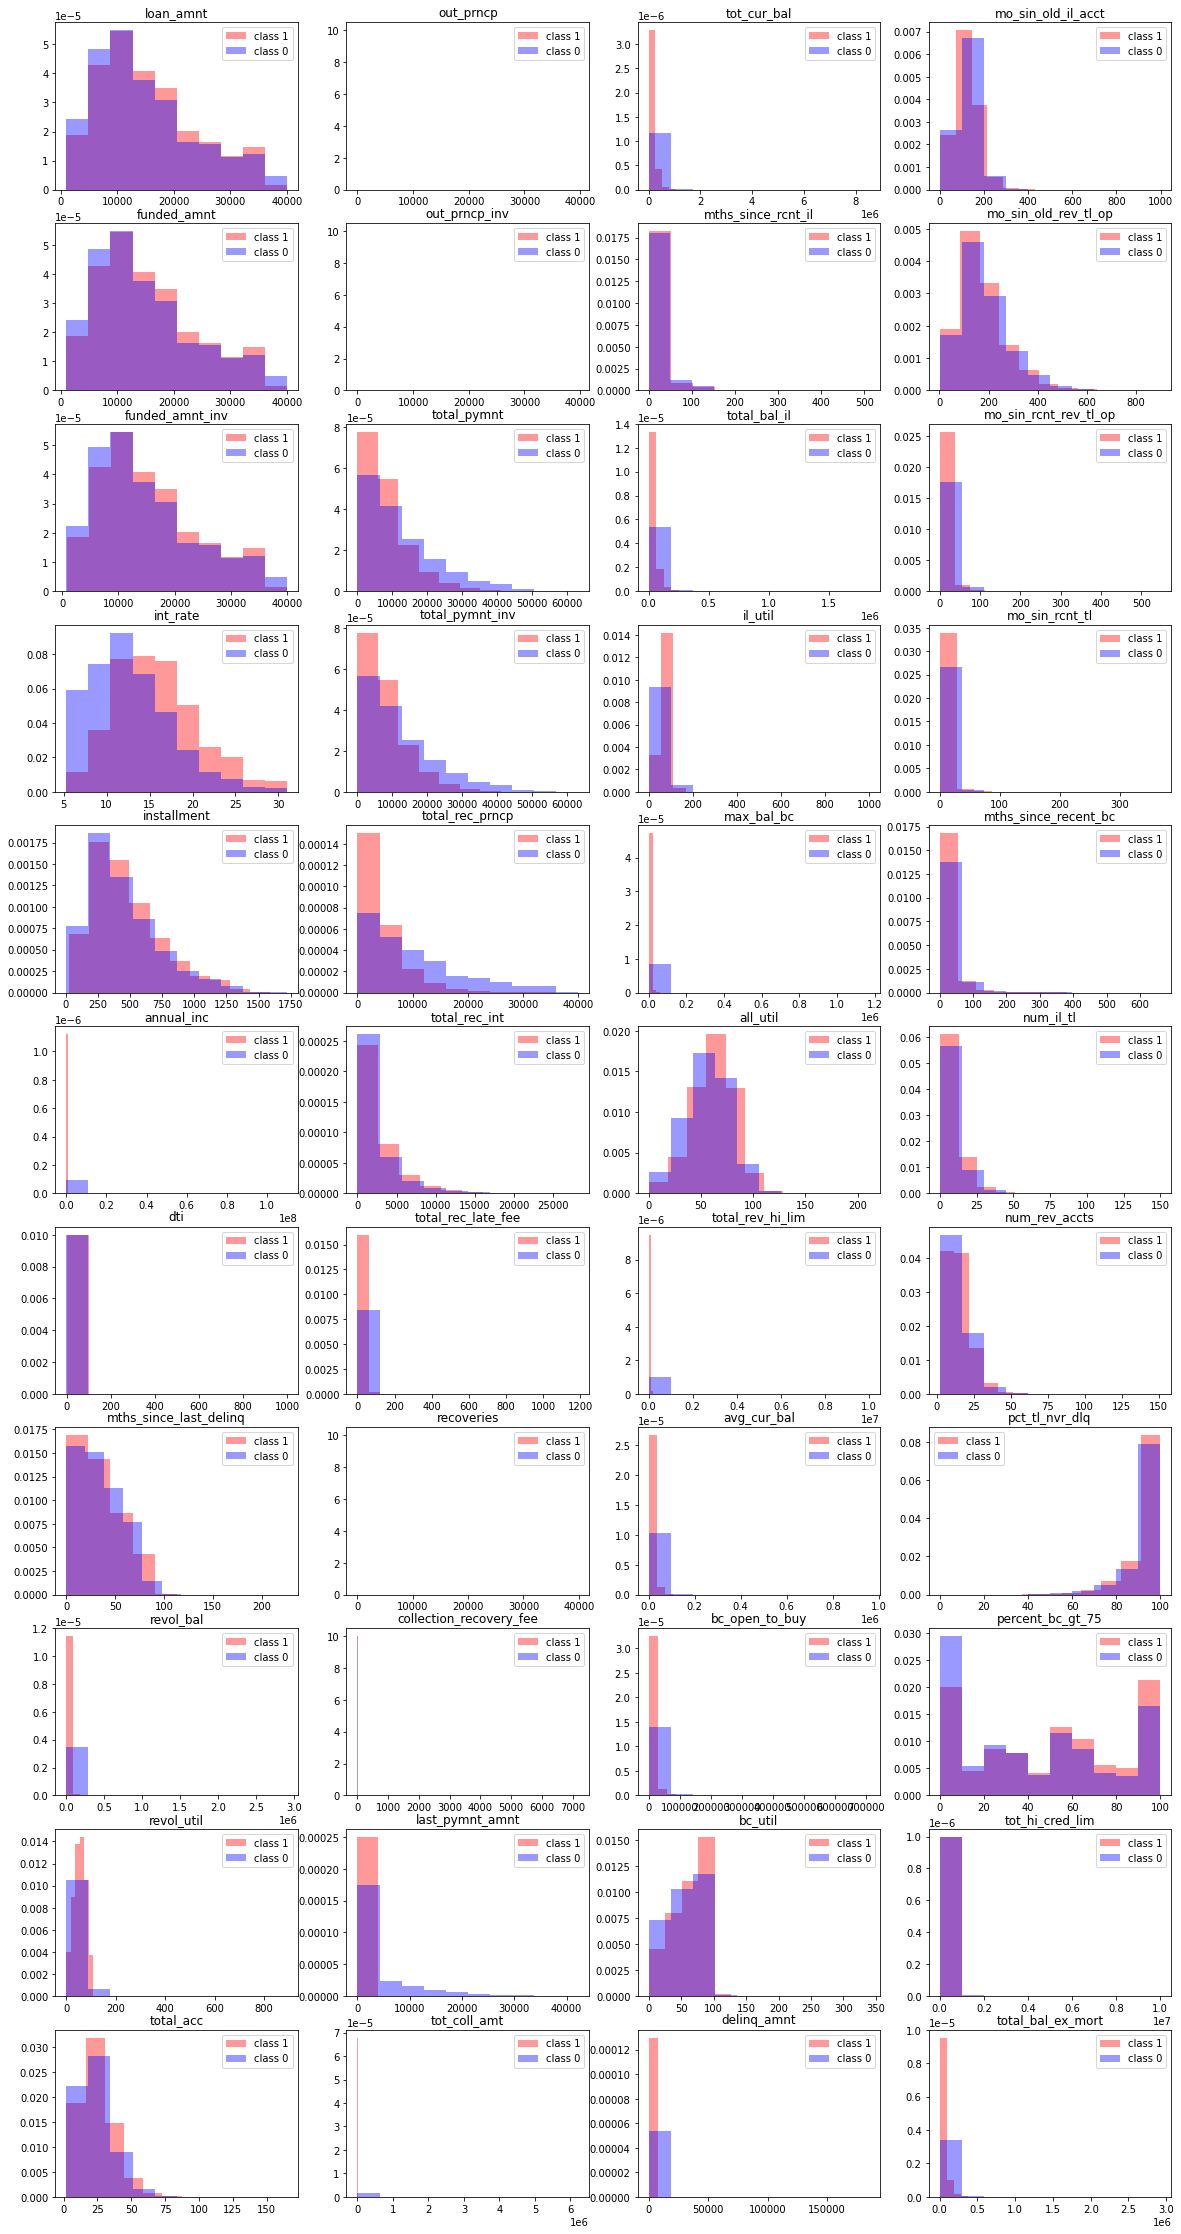

In [10]:
fig, ax = plt.subplots(11,4, figsize=(20,40))
for i in range(len(ax)):
  tmp = [numerical.columns[x] for x in range(len(numerical.columns)) if (x % len(ax) == i)]
  for j in range(len(ax[i])):
    ax[i][j].hist(train_data[tmp[j]][label == 1], color = 'r' , label= 'class 1', alpha = 0.4, density=True)
    ax[i][j].hist(train_data[tmp[j]][label == 0], color = 'b' , label= 'class 0', alpha = 0.4, density=True)
    ax[i][j].set_title(tmp[j])
    ax[i][j].legend()
plt.show()


In [21]:
feature_description['Description'][feature_description['LoanStatNew'] == 'mo_sin_old_rev_tl_op']

46    Months since oldest revolving account opened
Name: Description, dtype: object

In [22]:
np.var(data.loan_amnt)

85236525.33854577

In [11]:
suspective_leak_list = ['out_prncp_inv', 'total_bal_il','total_rev_hi_lim', 'annual_inc', 'avg_cur_bal', 
                   'collection_recovery_fee', 'bc_open_to_buy', 'last_pymnt_amnt', 'tot_hi_cred_lim', 
                   'revol_bal', 'tot_cur_bal', 'delinq_amnt', 'total_bal_ex_mort', 'tot_cur_bal', 'total_bc_limit', 'total_il_high_credit_limit']

In [12]:
print(suspective_leak_list)

['out_prncp_inv', 'total_bal_il', 'total_rev_hi_lim', 'annual_inc', 'avg_cur_bal', 'collection_recovery_fee', 'bc_open_to_buy', 'last_pymnt_amnt', 'tot_hi_cred_lim', 'revol_bal', 'tot_cur_bal', 'delinq_amnt', 'total_bal_ex_mort', 'tot_cur_bal', 'total_bc_limit', 'total_il_high_credit_limit']


In [13]:
def diag_hist(data, name):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5))
  fig.suptitle('The density histogram for ' + name)
  mean1 = np.mean(data[label == 1])
  mean0 = np.mean(data[label == 0])
  ax1.hist(data[label == 0], color= 'blue' , label= 'class 0', alpha = 0.5, density=True, bins = [i * int(mean0/10) for i in range(31)])
  ax2.hist(data[label == 1], color= 'red' , label= 'class 1', alpha = 0.5, density=True, bins = [i * int(mean1/10) for i in range(31)])
  ax1.legend()
  ax2.legend()
  plt.show()

In [14]:
def diag_boxplot(data, name):
  tmp0 = data[label == 0]
  tmp1 = data[label == 1]
  plt_data = pd.DataFrame({
      'class 0': tmp0[tmp0 != 0],
      'class 1': tmp1[tmp1 != 0]
      })
  plt_data.boxplot(grid=True, figsize = (8,5))
  plt.title('Boxplot for ' + name)
  plt.ylabel(name)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:908: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


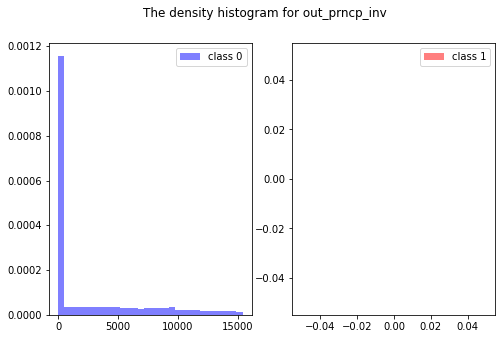

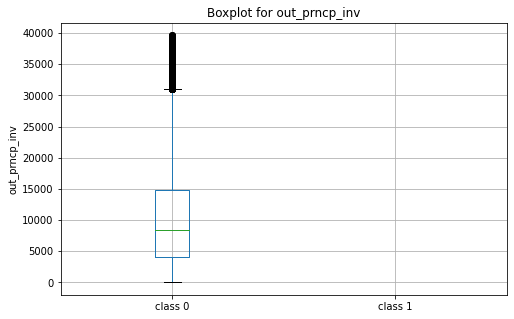

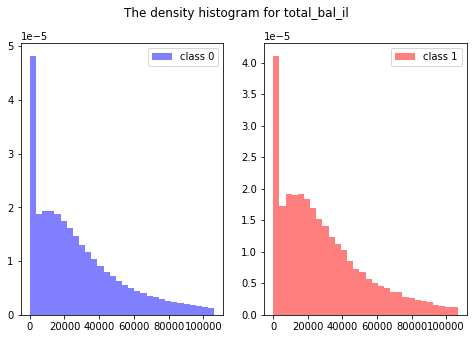

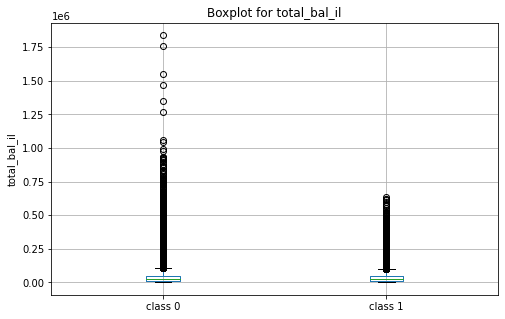

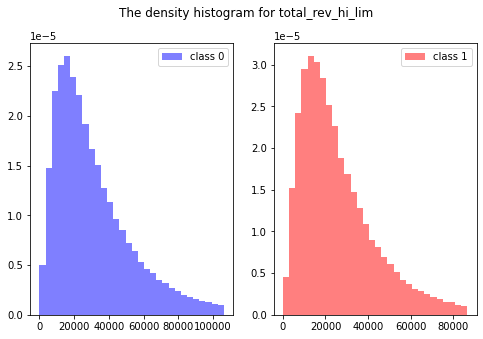

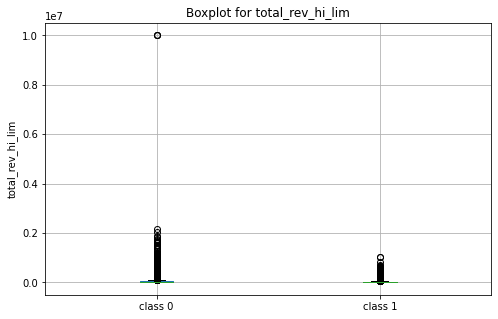

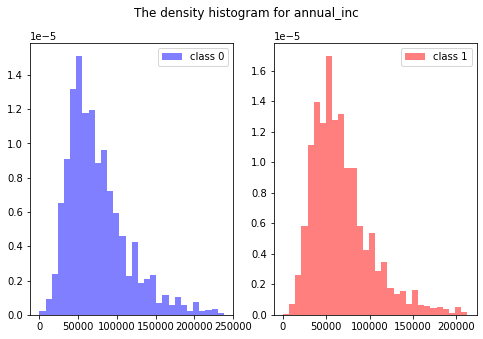

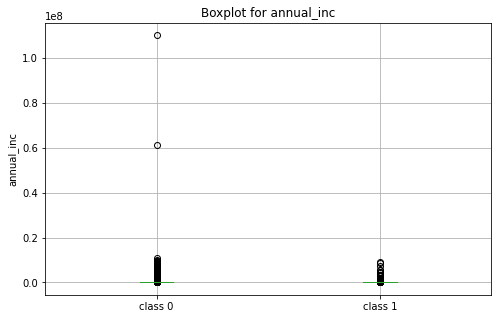

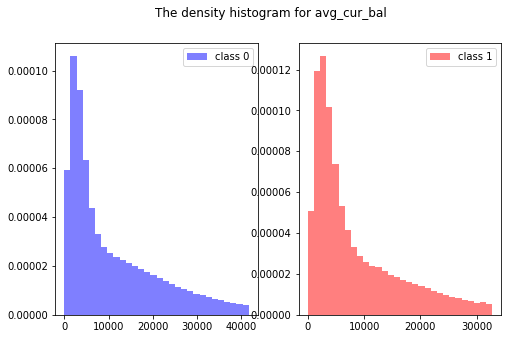

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:908: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


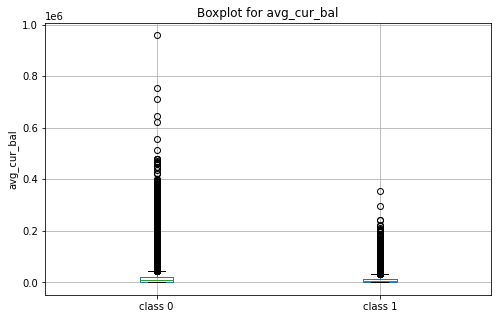

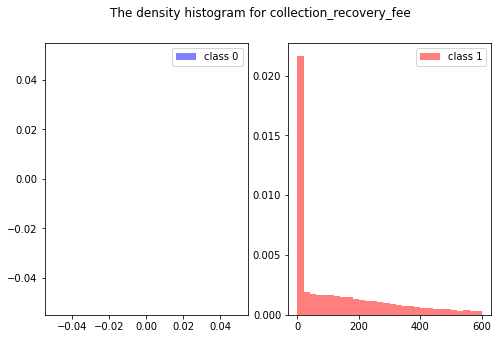

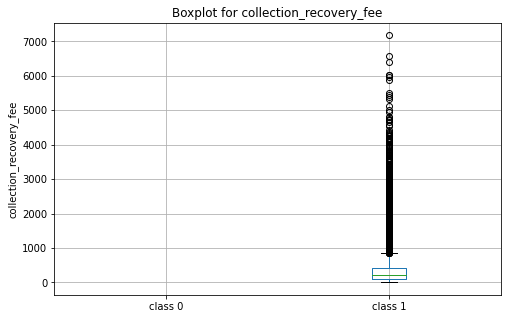

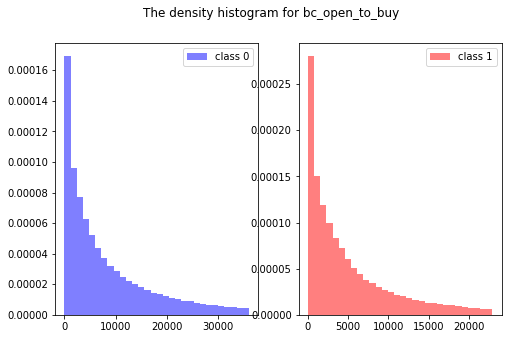

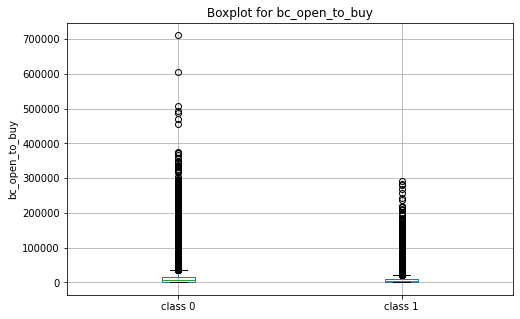

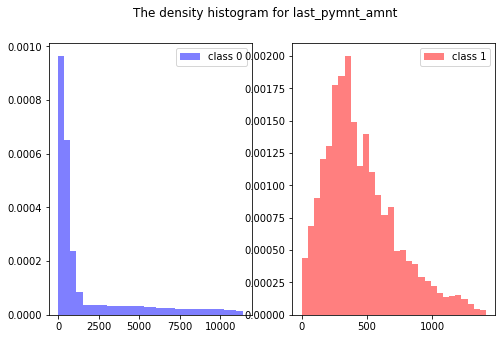

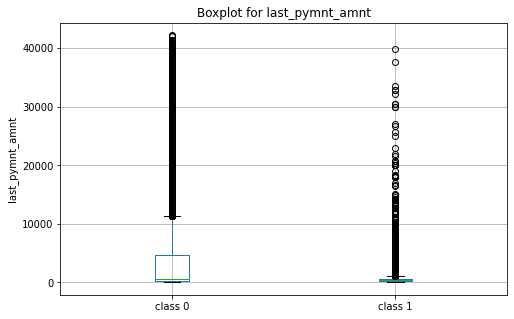

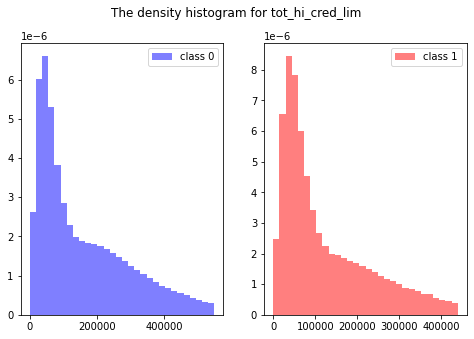

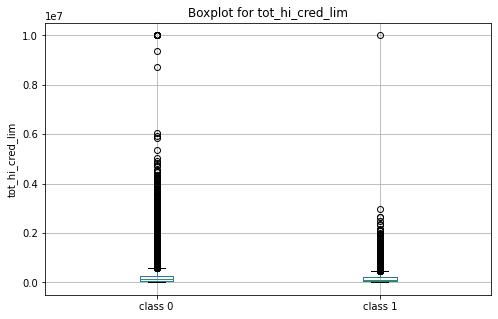

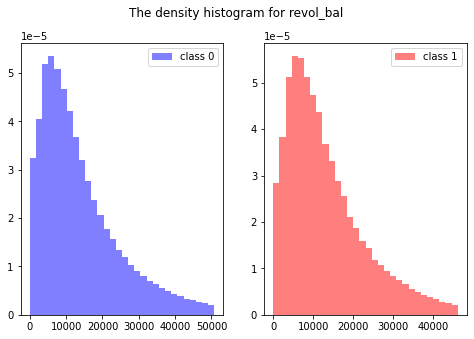

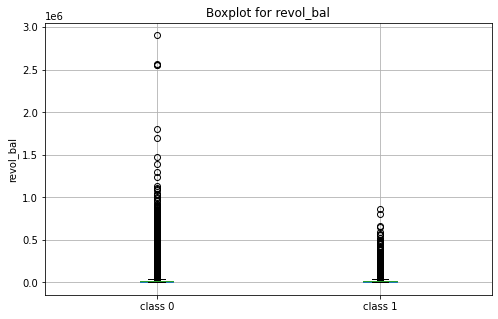

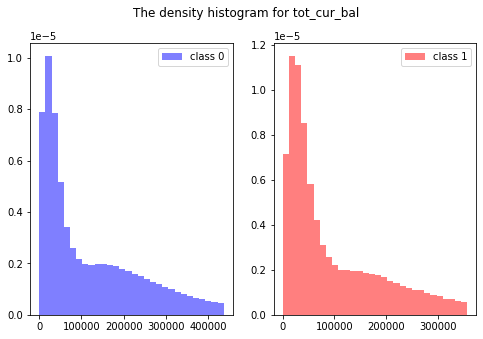

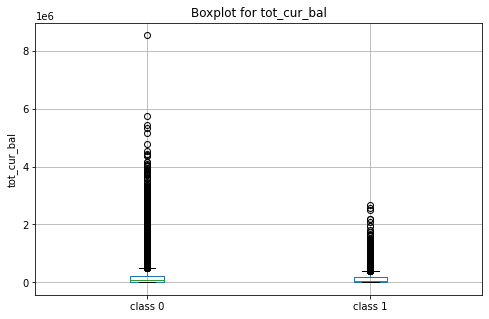

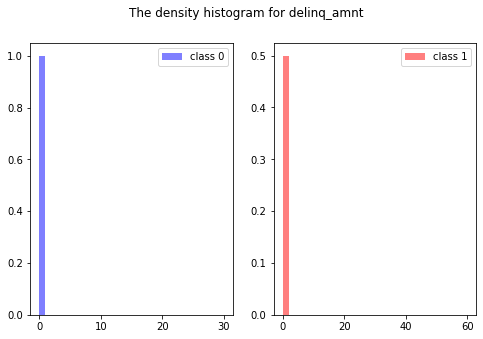

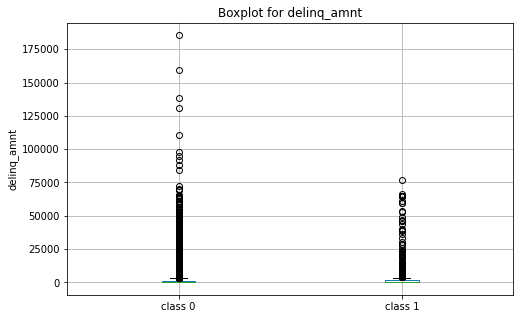

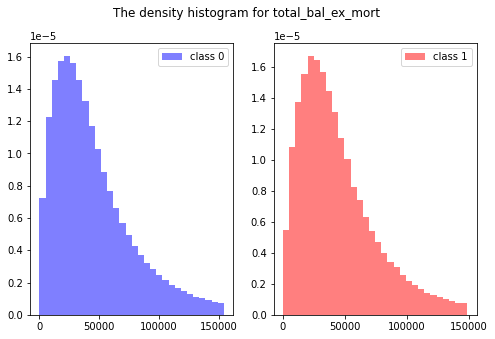

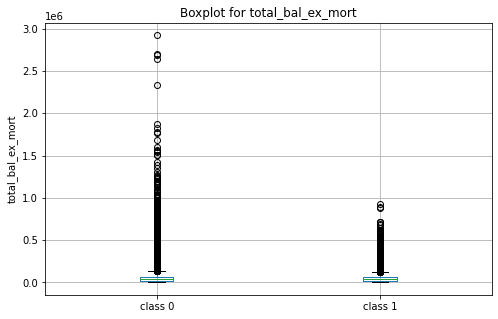

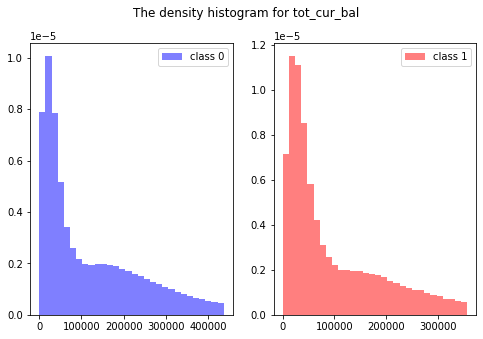

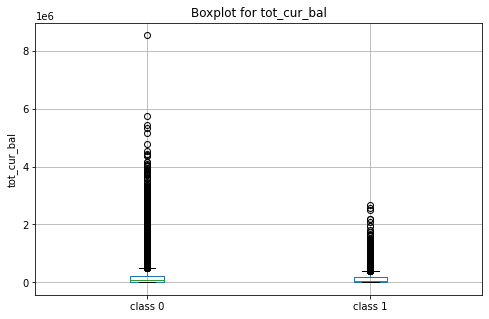

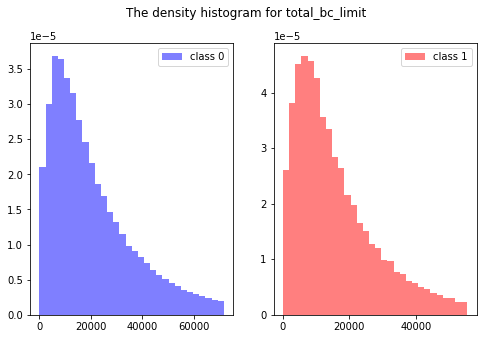

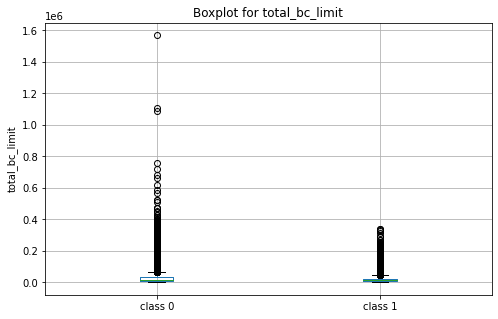

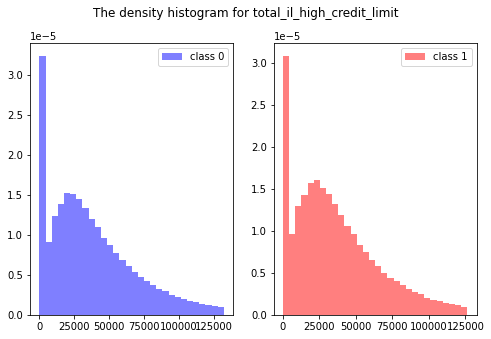

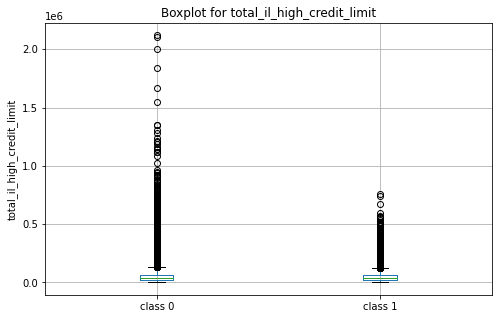

In [15]:
for x in suspective_leak_list:
  diag_hist(train_data[x], x)
  diag_boxplot(train_data[x], x)


* From the plot above, we have some highly suspective features, that is ```out_prncp_inv```, ```collection_recovery_fee```, ```delinq_amnt```. 

* Next step, we need to check the feature description again.

In [ ]:
for x in suspective_leak_list:
  for i in range(len(feature_description)):
    if feature_description['LoanStatNew'].iloc[i] == x:
      print((x,feature_description['Description'].iloc[i]))

('out_prncp_inv', 'Remaining outstanding principal for portion of total amount funded by investors')
('total_bal_il', 'Total current balance of all installment accounts')
('annual_inc', 'The self-reported annual income provided by the borrower during registration.')
('avg_cur_bal', 'Average current balance of all accounts')
('collection_recovery_fee', 'post charge off collection fee')
('bc_open_to_buy', 'Total open to buy on revolving bankcards.')
('last_pymnt_amnt', 'Last total payment amount received')
('tot_hi_cred_lim', 'Total high credit/credit limit')
('revol_bal', 'Total credit revolving balance')
('tot_cur_bal', 'Total current balance of all accounts')
('delinq_amnt', 'The past-due amount owed for the accounts on which the borrower is now delinquent.')
('total_bal_ex_mort', 'Total credit balance excluding mortgage')
('tot_cur_bal', 'Total current balance of all accounts')
('total_bc_limit', 'Total bankcard high credit/credit limit')
('total_il_high_credit_limit', 'Total install

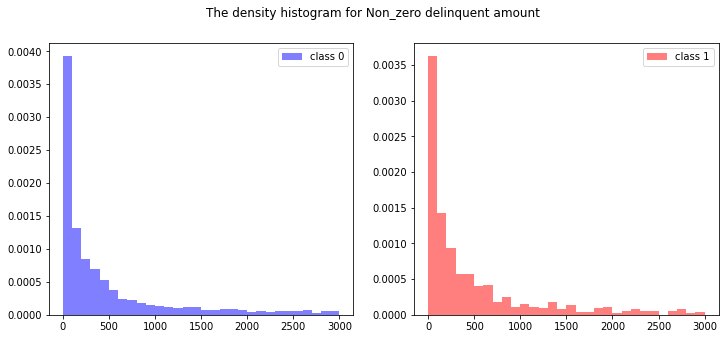

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('The density histogram for Non_zero delinquent amount')
tmp0 = train_data.delinq_amnt[label == 0]
tmp1 = train_data.delinq_amnt[label == 1]
ax1.hist(tmp0[tmp0 != 0.0], color= 'blue' , label= 'class 0', alpha = 0.5, density=True, bins = [i * 100  for i in range(31)])
ax2.hist(tmp1[tmp1 != 0.0], color= 'red' , label= 'class 1', alpha = 0.5, density=True, bins = [i * 100 for i in range(31)])
ax1.legend()
ax2.legend()
plt.show()

* Delinquent loans and leases are those past due thirty days or more and still accruing interest as well as those in nonaccrual status.

* According to federal regulations, installment loans (like student loans) must be charged-off after being delinquent for 120 days.

* Therefore, deliquent amount might be a highly related feature instead of leakage feature. 

### Retrain the model

In [ ]:
numerical3 = numerical3.drop(['out_prncp_inv', 'collection_recovery_fee'], axis = 1)
numerical_test3 = numerical_test3.drop(['out_prncp_inv', 'collection_recovery_fee'], axis = 1)

In [ ]:
y_train = np.array(y_train.astype(int))
sample_x, rest_x, sample_y, rest_y = model_selection.train_test_split(numerical3, y_train, train_size=0.2,test_size=0.8, random_state=100)

In [ ]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors= 3, weights="uniform")
sample_x = knn_imputer.fit_transform(sample_x)

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(sample_x, sample_y)
param = {'max_depth':4, 'objective':'binary:logistic', 'nthread': 8, 'eval_metric': 'auc' , 'learning_rate': 0.05 }

num_round = 300
bst = xgb.train(param, dtrain, num_round)

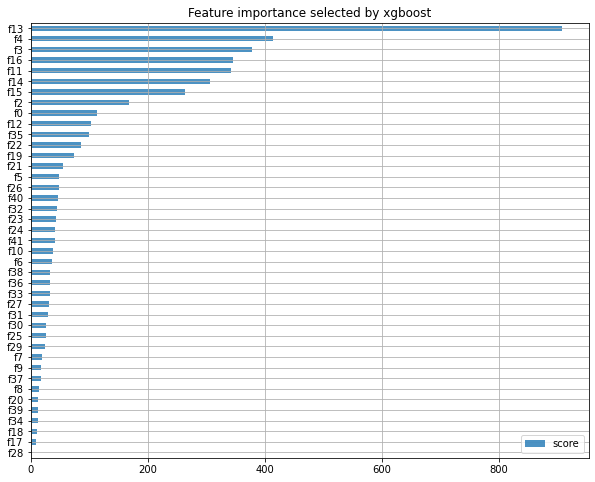

In [ ]:
feature_important = bst.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

feature_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
feature_importance.plot(kind='barh', grid=True, figsize = (10,8), alpha = 0.8, legend = True, title = 'Feature importance selected by xgboost')

In [ ]:
feature_importance.score

f28      1
f17      9
f18     11
f34     12
f39     13
f20     13
f8      14
f37     17
f9      18
f7      19
f29     25
f25     26
f30     27
f31     30
f27     32
f33     33
f36     33
f38     34
f6      37
f10     38
f41     42
f24     42
f23     43
f32     46
f40     47
f26     48
f5      48
f21     55
f19     74
f22     87
f35     99
f12    103
f0     114
f2     169
f15    263
f14    306
f11    343
f16    346
f3     378
f4     414
f13    908
Name: score, dtype: int64

In [ ]:
selected_features = feature_importance.index[feature_importance.score > 50]
selected_features

Index(['f21', 'f19', 'f22', 'f35', 'f12', 'f0', 'f2', 'f15', 'f14', 'f11',
       'f16', 'f3', 'f4', 'f13'],
      dtype='object')

In [ ]:

selected_features_index = [int(x[1:]) for x in selected_features]
features_names = list(numerical3.columns[selected_features_index])

selected_column_index = []
for x in features_names:
  for i in range(len(X_test.columns)):
    if X_test.columns[i] == x:
      selected_column_index.append(i)

In [ ]:
selected_features_index

[21, 19, 22, 35, 12, 0, 2, 15, 14, 11, 16, 3, 4, 13]

In [ ]:
selected_feature_test = np.array(X_test[features_names])
# y_test = np.array(y_test.astype(int))

In [ ]:
features_names

['il_util',
 'mths_since_rcnt_il',
 'max_bal_bc',
 'num_rev_accts',
 'total_pymnt_inv',
 'loan_amnt',
 'funded_amnt_inv',
 'total_rec_late_fee',
 'total_rec_int',
 'total_pymnt',
 'last_pymnt_amnt',
 'int_rate',
 'installment',
 'total_rec_prncp']

In [ ]:
sample_x_test, rest_x_test, sample_y_test, rest_y_test = model_selection.train_test_split(selected_feature_test, y_test, train_size=0.3,test_size=0.7, random_state=1)


In [ ]:
selected_feature_test = knn_imputer.fit_transform(sample_x_test)

In [ ]:
np.isnan(selected_feature_test).sum()

0

In [ ]:
from sklearn import preprocessing


In [ ]:
def standardized(selected_features, sample_x):
    '''
    selected_features (object format): index of features started by the character 'f'
    sample_x (numpy array): sample matrix
    output: standardlized sample matrix with selected feature
    '''
    selected_features = [int(x[1:]) for x in selected_features]
    sample_feature_x = sample_x[:,selected_features]
    scaler = preprocessing.StandardScaler().fit(sample_feature_x)
    sample_feature_x = scaler.transform(sample_feature_x)
    return sample_feature_x

In [ ]:
sample_feature_x = standardized(selected_features, sample_x)

In [ ]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
# generate dataset

weights = {0: 1,1:0.085}
lr = LogisticRegression(solver='lbfgs', class_weight= weights, penalty = 'l2', C = 100, n_jobs = -1, max_iter = 300)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(lr, sample_feature_x, sample_y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.933


In [ ]:
scores

array([0.93263681, 0.93621325, 0.93600303, 0.93592006, 0.93181594,
       0.93254069, 0.93583424, 0.93577366, 0.92588486, 0.93243396,
       0.92904692, 0.93715383, 0.92964932, 0.93588419, 0.9323561 ,
       0.93532986, 0.93950814, 0.9304704 , 0.93179593, 0.93350353,
       0.93327381, 0.93510906, 0.93637263, 0.93455217, 0.9322473 ,
       0.93301321, 0.94013405, 0.9280433 , 0.92792583, 0.93434743])

In [ ]:
sample_y_test = np.array(sample_y_test.astype(int))


In [ ]:
scaler = preprocessing.StandardScaler().fit(selected_feature_test)
sample_x_test = scaler.transform(selected_feature_test)
from sklearn import metrics
lr = LogisticRegression(solver='lbfgs', class_weight= 'balanced', penalty = 'l2', C = 5, n_jobs = -1, max_iter = 300)

pred = lr.fit(sample_feature_x, sample_y).predict(sample_x_test)
fpr, tpr, thresholds = metrics.roc_curve(sample_y_test, pred)
metrics.auc(fpr, tpr)

0.8422499403423156

In [ ]:
scaler = preprocessing.StandardScaler().fit(selected_feature_test)
sample_x_test = scaler.transform(selected_feature_test)
from sklearn import metrics
lr = LogisticRegression(solver='lbfgs', class_weight= 'balanced', penalty = 'l2', C = 1000, n_jobs = -1, max_iter = 300)

pred = lr.fit(sample_feature_x, sample_y).predict(sample_x_test)
fpr, tpr, thresholds = metrics.roc_curve(sample_y_test, pred)
metrics.auc(fpr, tpr)

0.8332312078736356

In [ ]:
scaler = preprocessing.StandardScaler().fit(selected_feature_test)
scaler.transform(selected_feature_test)

array([[ 0.11794129, -0.48676681, -0.69268173, ..., -0.52128553,
        -0.22802316, -0.75782871],
       [ 0.43621841, -0.57412706, -0.45681495, ..., -0.19361941,
         0.31405619, -0.4215342 ],
       [ 0.11794129, -0.04996559, -1.00522347, ..., -0.06213556,
        -0.74340553, -0.91397538],
       ...,
       [-0.40135295, -0.54500698, -0.64004376, ...,  0.97095188,
         0.59644675,  1.73446775],
       [-0.9876529 , -0.09364571, -0.24212506, ...,  2.08543408,
        -0.39234959, -0.69486483],
       [ 0.3692127 , -0.2683662 ,  1.88791749, ..., -0.98878368,
         2.43611126,  3.02661032]])

## Next step: 

1. Examine correlation between variables

2. Only use selected features for X_train, slice training data, and do imputation on the <strong>whole dataset</strong> instead of the subsample one.  

3. Try some new algorithms, including SVM, Random Forest, XgBoost. 

In [ ]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(solver='lbfgs', penalty = 'l2',  n_jobs = -1, max_iter = 200)

C = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500]
weights = {0: 1,1:0.085}
class_weight = ['balanced', weights]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)


random_grid = {'C': C, 
               'class_weight': class_weight
               
              }


lr_search = GridSearchCV(estimator = lr, param_grid = random_grid, cv = cv, scoring='roc_auc')
lr_search.fit(sample_feature_x, sample_y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=1),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500],
                         'class_weight': ['balanced', {0: 1, 1: 0.085}]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [ ]:
lr_search.score(sample_feature_x, sample_y)

0.938122858766601

In [ ]:
lr = LogisticRegression(solver='lbfgs', penalty = 'l2',  n_jobs = -1, max_iter = 200, C = 100, class_weight = 'balanced')
pred = lr.fit(sample_feature_x, sample_y).predict(sample_x_test)
fpr, tpr, thresholds = metrics.roc_curve(sample_y_test, pred)
metrics.auc(fpr, tpr)

0.840326274991792